<a href="https://colab.research.google.com/github/Undasnr/DL-ML/blob/main/Ronny_Deep_Neural_Assignment_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 60000, Test samples: 10000
Displaying sample MNIST images...


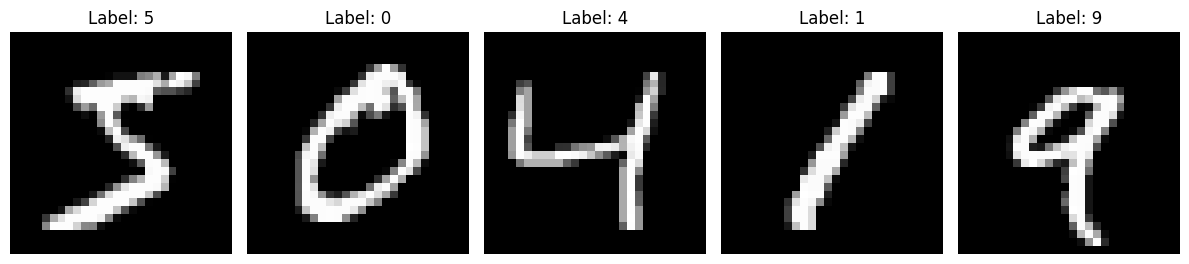

Initializing neural network with SGD optimizer...
Starting training with mini-batches...
Epoch 1/10 - Loss: 2.3224
Epoch 2/10 - Loss: 2.1924
Epoch 3/10 - Loss: 2.0950
Epoch 4/10 - Loss: 2.0043
Epoch 5/10 - Loss: 1.9136
Epoch 6/10 - Loss: 1.8214
Epoch 7/10 - Loss: 1.7265
Epoch 8/10 - Loss: 1.6285
Epoch 9/10 - Loss: 1.5306
Epoch 10/10 - Loss: 1.4374
Training Accuracy: 69.46%
Test Accuracy: 70.92%


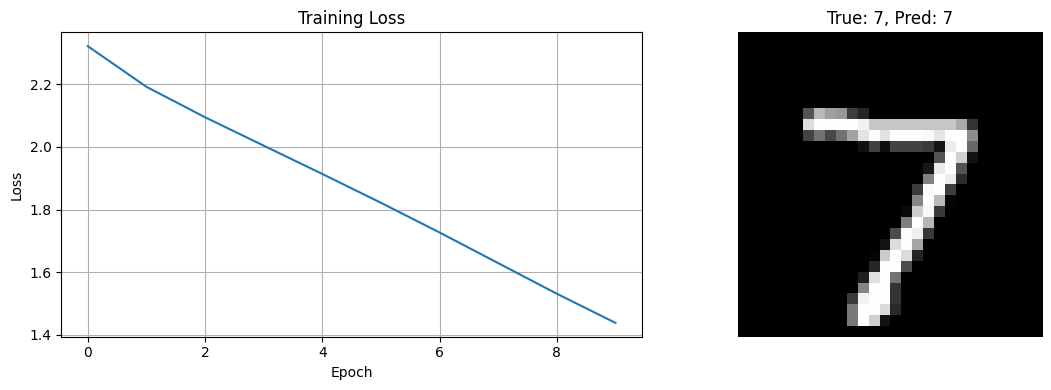

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.datasets import mnist

class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.X = None
        self.dW = None
        self.dB = None

    def forward(self, X):
        self.X = X
        A = np.dot(X, self.W) + self.B
        return A

    def backward(self, dA):
        batch_size = dA.shape[0]
        self.dW = np.dot(self.X.T, dA) / batch_size
        self.dB = np.sum(dA, axis=0) / batch_size
        dZ = np.dot(dA, self.W.T)
        self = self.optimizer.update(self)
        return dZ

class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

class XavierInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        sigma = 1 / np.sqrt(n_nodes1)
        return sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

class HeInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2 / n_nodes1)
        return sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

# Optimization Methods
class SGD:
    """
    Stochastic Gradient Descent optimizer - PROPERLY IMPLEMENTED
    """
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, layer):
        """
        Update weights and biases using SGD
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.hW = None
        self.hB = None

    def update(self, layer):
        if self.hW is None:
            self.hW = np.zeros_like(layer.W)
        if self.hB is None:
            self.hB = np.zeros_like(layer.B)

        self.hW += layer.dW ** 2
        self.hB += layer.dB ** 2

        layer.W -= self.lr * layer.dW / (np.sqrt(self.hW) + 1e-7)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.hB) + 1e-7)
        return layer

# Activation Functions
class Sigmoid:
    def __init__(self):
        self.Z = None

    def forward(self, A):
        self.Z = 1 / (1 + np.exp(-A))
        return self.Z

    def backward(self, dZ):
        dA = dZ * (1 - self.Z) * self.Z
        return dA

class ReLU:
    def __init__(self):
        self.A = None

    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z

    def backward(self, dZ):
        dA = dZ.copy()
        dA[self.A <= 0] = 0
        return dA

class Softmax:
    def __init__(self):
        self.Z = None

    def forward(self, A):
        A_stable = A - np.max(A, axis=1, keepdims=True)
        exp_A = np.exp(A_stable)
        self.Z = exp_A / np.sum(exp_A, axis=1, keepdims=True)
        return self.Z

    def backward(self, Z, y_true):
        batch_size = y_true.shape[0]
        dA = (Z - y_true) / batch_size
        return dA

    def cross_entropy_error(self, Z, y_true):
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(Z + 1e-7)) / batch_size
        return loss

class ScratchDeepNeuralNetworkClassifier:
    """
    Deep neural network classifier with proper mini-batch implementation
    """
    def __init__(self, n_features, n_nodes, n_output, activations, initializer, optimizer, epochs=50, batch_size=20, verbose=True):
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.loss = []
        self.n_features = n_features
        self.n_output = n_output
        self.n_nodes = n_nodes
        self.layers = []

        # Create new optimizer instances for each layer
        optimizer_class = optimizer.__class__
        lr = optimizer.lr

        # Input layer to first hidden layer
        self.layers.append(FC(n_features, n_nodes[0], initializer, optimizer_class(lr=lr)))
        self.layers.append(activations[0])

        # Hidden layers
        for i in range(len(n_nodes) - 1):
            self.layers.append(FC(n_nodes[i], n_nodes[i+1], initializer, optimizer_class(lr=lr)))
            self.layers.append(activations[i+1])

        # Output layer
        self.layers.append(FC(n_nodes[-1], n_output, initializer, optimizer_class(lr=lr)))
        self.layers.append(Softmax())

    def fit(self, X, y):
        """Mini-batch training implementation"""
        y_one_hot = np.eye(self.n_output)[y.astype(int).reshape(-1)]

        for epoch in range(self.epochs):
            # Shuffle data for each epoch
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y_one_hot[indices]

            epoch_loss = 0
            num_batches = 0

            # Process mini-batches
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                # Skip empty batches
                if len(X_batch) == 0:
                    continue

                # Forward pass
                A = X_batch
                for layer in self.layers:
                    A = layer.forward(A)

                # Calculate loss
                loss = self.layers[-1].cross_entropy_error(A, y_batch)
                epoch_loss += loss
                num_batches += 1

                # Backward pass
                dA = self.layers[-1].backward(A, y_batch)
                for layer in reversed(self.layers[:-1]):
                    dA = layer.backward(dA)

            avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
            self.loss.append(avg_loss)

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs} - Loss: {avg_loss:.4f}")

    def predict(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return np.argmax(A, axis=1)

def display_mnist_images(X, y, num_images=5):
    """Display MNIST images with their labels"""
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        img = X[i].reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {y[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def main():
    print("Loading MNIST dataset...")
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Preprocess data
    X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
    X_test = X_test.reshape(-1, 784).astype(np.float32) / 255.0

    print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

    # Display some MNIST images
    print("Displaying sample MNIST images...")
    display_mnist_images(X_train, y_train, num_images=5)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    n_features = X_train.shape[1]
    n_output = len(np.unique(y_train))

    # Network configuration - USING SGD OPTIMIZER
    n_nodes_hidden = [128, 64]
    activations = [ReLU(), ReLU()]
    initializer = HeInitializer()
    optimizer = SGD(lr=0.01)  # Using SGD optimizer
    epochs = 10
    batch_size = 64  # Proper mini-batch size

    print("Initializing neural network with SGD optimizer...")
    nn = ScratchDeepNeuralNetworkClassifier(
        n_features=n_features,
        n_nodes=n_nodes_hidden,
        n_output=n_output,
        activations=activations,
        initializer=initializer,
        optimizer=optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose=True
    )

    print("Starting training with mini-batches...")
    nn.fit(X_train, y_train)

    # Evaluate
    y_pred_train = nn.predict(X_train)
    y_pred_test = nn.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(nn.loss)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Display a test prediction example
    sample_idx = 0
    sample_img = X_test[sample_idx].reshape(28, 28)
    true_label = y_test[sample_idx]
    pred_label = y_pred_test[sample_idx]

    plt.imshow(sample_img, cmap='gray')
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()